In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


In [2]:
build_ener_df = pd.read_csv("2016_Building_Energy_Benchmarking.csv")
with pd.option_context("display.max_columns", None):
    display(build_ener_df)


,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,7,DOWNTOWN,47.61220,-122.33799,1927,1.0,12,88434,0,88434,Hotel,Hotel,88434.0,NaN,NaN,NaN,NaN,NaN,60.0,81.699997,84.300003,182.500000,189.000000,7.226362e+06,7.456910e+06,2003882.00,1.156514e+06,3.946027e+06,12764.529300,1.276453e+06,False,NaN,Compliant,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,7,DOWNTOWN,47.61317,-122.33393,1996,1.0,11,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,NaN,61.0,94.800003,97.900002,176.100006,179.399994,8.387933e+06,8.664479e+06,0.00,9.504252e+05,3.242851e+06,51450.816410,5.145082e+06,False,NaN,Compliant,NaN,295.86,2.86
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,7,DOWNTOWN,47.61393,-122.33810,1969,1.0,41,956110,196718,759392,Hotel,Hotel,756493.0,NaN,NaN,NaN,NaN,NaN,43.0,96.000000,97.699997,241.899994,244.100006,7.258702e+07,7.393711e+07,21566554.00,1.451544e+07,4.952666e+07,14938.000000,1.493800e+06,False,NaN,Compliant,NaN,2089.28,2.19
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.0,0659000640,7,DOWNTOWN,47.61412,-122.33664,1926,1.0,10,61320,0,61320,Hotel,Hotel,61320.0,NaN,NaN,NaN,NaN,NaN,56.0,110.800003,113.300003,216.199997,224.000000,6.794584e+06,6.946800e+06,2214446.25,8.115253e+05,2.768924e+06,18112.130860,1.811213e+06,False,NaN,Compliant,NaN,286.43,4.67
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.0,0659000970,7,DOWNTOWN,47.61375,-122.34047,1980,1.0,18,175580,62000,113580,"Hotel, Parking, Swimming Pool",Hotel,123445.0,Parking,68009.0,Swimming Pool,0.0,NaN,75.0,114.800003,118.699997,211.399994,215.600006,1.417261e+07,1.465650e+07,0.00,1.573449e+06,5.368607e+06,88039.984380,8.803998e+06,False,NaN,Compliant,NaN,505.01,2.88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3371,50222,2016,Nonresidential COS,Office,Horticulture building,1600 S Dakota St,Seattle,WA,NaN,1624049080,2,GREATER DUWAMISH,47.56722,-122.31154,1990,1.0,1,12294,0,12294,Office,Office,12294.0,NaN,NaN,NaN,NaN,NaN,46.0,69.099998,76.699997,161.699997,176.100006,8.497457e+05,9.430032e+05,0.00,1.536550e+05,5.242709e+05,3254.750244,3.254750e+05,True,NaN,Error - Correct Default Data,NaN,20.94,1.70
3372,50223,2016,Nonresidential COS,Other,International district/Chinatown CC,719 8th Ave S,Seattle,WA,NaN,3558300000,2,DOWNTOWN,47.59625,-122.32283,2004,1.0,1,16000,0,16000,Other - Recreation,Other - Recreation,16000.0,NaN,NaN,NaN,NaN,NaN,NaN,59.400002,65.900002,114.199997,118.900002,9.502762e+05,1.053706e+06,0.00,1.162210e+05,3.965461e+05,5537.299805,5.537300e+05,False,NaN,Compliant,NaN,32.17,2.01
3373,50224,2016,Nonresidential COS,Other,Queen Anne Pool,1920 1st Ave W,Seattle,WA,NaN,1794501150,7,MAGNOLIA / QUEEN ANNE,47.63644,-122.35784,1974,1.0,1,13157,0,13157,"Fitness Center/Health Club/Gym, Other - Recrea...",Other - Recreation,7583.0,Fitness Center/Health Club/Gym,5574.0,Swimmin

In [3]:
print(
    f"{build_ener_df.shape[0]} rows\n{len(np.unique(build_ener_df['OSEBuildingID'].to_numpy()))} unique \"OSEBuildingID\""
)


3376 rows
3376 unique "OSEBuildingID"


In [45]:
print(
    '"ComplianceStatus" unique entries:\n\t'
    + "\n\t".join(sorted([f"{i}" for i in set(build_ener_df["ComplianceStatus"].to_numpy())]))
)

print(
    '"Outlier" unique entries:\n\t'
    + "\n\t".join(sorted([f"{i}" for i in set(build_ener_df["Outlier"].to_numpy())]))
)


"ComplianceStatus" unique entries:
	Compliant
	Error - Correct Default Data
	Missing Data
	Non-Compliant
"Outlier" unique entries:
	High outlier
	Low outlier
	nan


In [ ]:
ComplianceStatus
Outlier

In [5]:
print(
    '"BuildingType" unique entries:\n\t'
    + "\n\t".join(
        sorted([f"{i}" for i in set(build_ener_df["BuildingType"].to_numpy())])
    )
)


"BuildingType" unique entries:
	Campus
	Multifamily HR (10+)
	Multifamily LR (1-4)
	Multifamily MR (5-9)
	NonResidential
	Nonresidential COS
	Nonresidential WA
	SPS-District K-12


School/business campus
Multifamily High-rise (10 or more floors)
Multifamily Low-rise (1 to 4 floors)
Multifamily Mid-rise (5 to 9 floors)
Non-residential
Non-residential belonging to the City of Seattle
Non-residential belonging to Washington State
Seattle Public Schools District - Kindergarten through 12th grade

No single family residential

In [6]:
print(
    '"PrimaryPropertyType" unique entries:\n\t'
    + "\n\t".join(
        sorted([f"{i}" for i in set(build_ener_df["PrimaryPropertyType"].to_numpy())])
    )
)

"PrimaryPropertyType" unique entries:
	Distribution Center
	High-Rise Multifamily
	Hospital
	Hotel
	K-12 School
	Laboratory
	Large Office
	Low-Rise Multifamily
	Medical Office
	Mid-Rise Multifamily
	Mixed Use Property
	Office
	Other
	Refrigerated Warehouse
	Residence Hall
	Restaurant
	Retail Store
	Self-Storage Facility
	Senior Care Community
	Small- and Mid-Sized Office
	Supermarket / Grocery Store
	University
	Warehouse
	Worship Facility


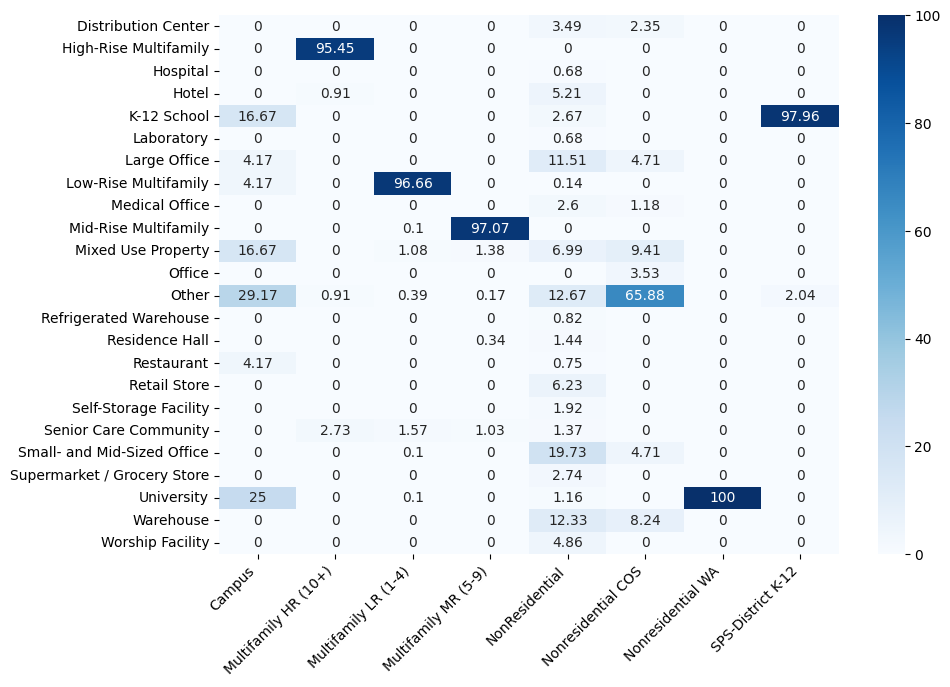

In [7]:
build_types = sorted([f"{i}" for i in set(build_ener_df["BuildingType"].to_numpy())])
prop_types = sorted(
    [f"{i}" for i in set(build_ener_df["PrimaryPropertyType"].to_numpy())]
)
build_and_prop = {}

for build_type in build_types:
    prop_type_vals = {}
    build_type_total = prop_type_total = len(
        build_ener_df[build_ener_df["BuildingType"] == build_type]
    )

    for prop_type in prop_types:
        prop_type_vals[prop_type] = round(
            100
            * (
                len(
                    build_ener_df[
                        (build_ener_df["PrimaryPropertyType"] == prop_type)
                        & (build_ener_df["BuildingType"] == build_type)
                    ]
                )
                / build_type_total
            ),
            2,
        )

    build_and_prop[build_type] = prop_type_vals

fig, ax = plt.subplots(figsize=(10, 7))
sns.heatmap(
    data=pd.DataFrame(build_and_prop),
    cmap=sns.color_palette("Blues", as_cmap=True),
    annot=True,
    fmt="g",
    ax=ax,
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment="right")
plt.show()


In [8]:
build_ener_df.loc[build_ener_df["BuildingType"] == "Nonresidential WA"]

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
3359,50101,2016,Nonresidential WA,University,Burke Museum,4331 Memorial Way NE,Seattle,WA,98195.0,1625049001,...,932244.6875,3180819.0,0.0,0.0,False,NaN,Compliant,NaN,22.17,0.33


In [9]:
print(
    '"City" unique entries:\n\t'
    + "\n\t".join(sorted([f"{i}" for i in set(build_ener_df["City"].to_numpy())]))
)

"City" unique entries:
	Seattle


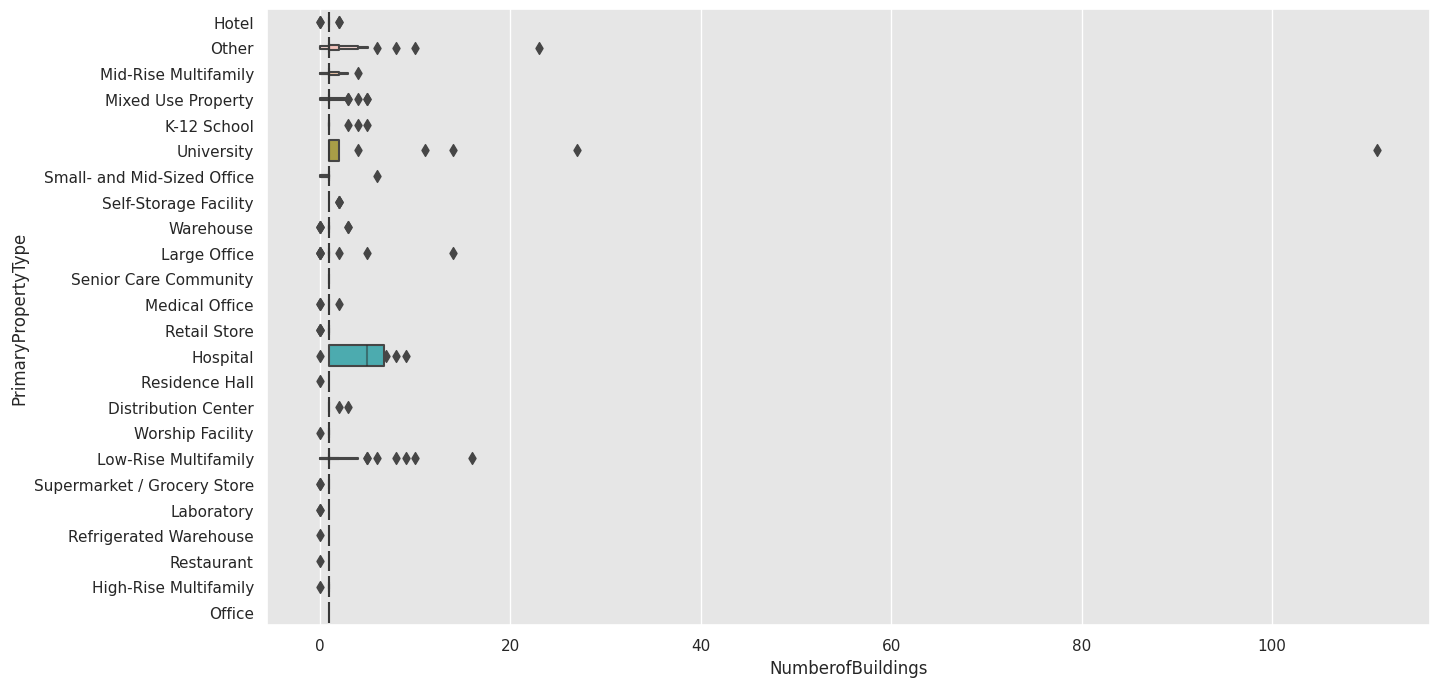

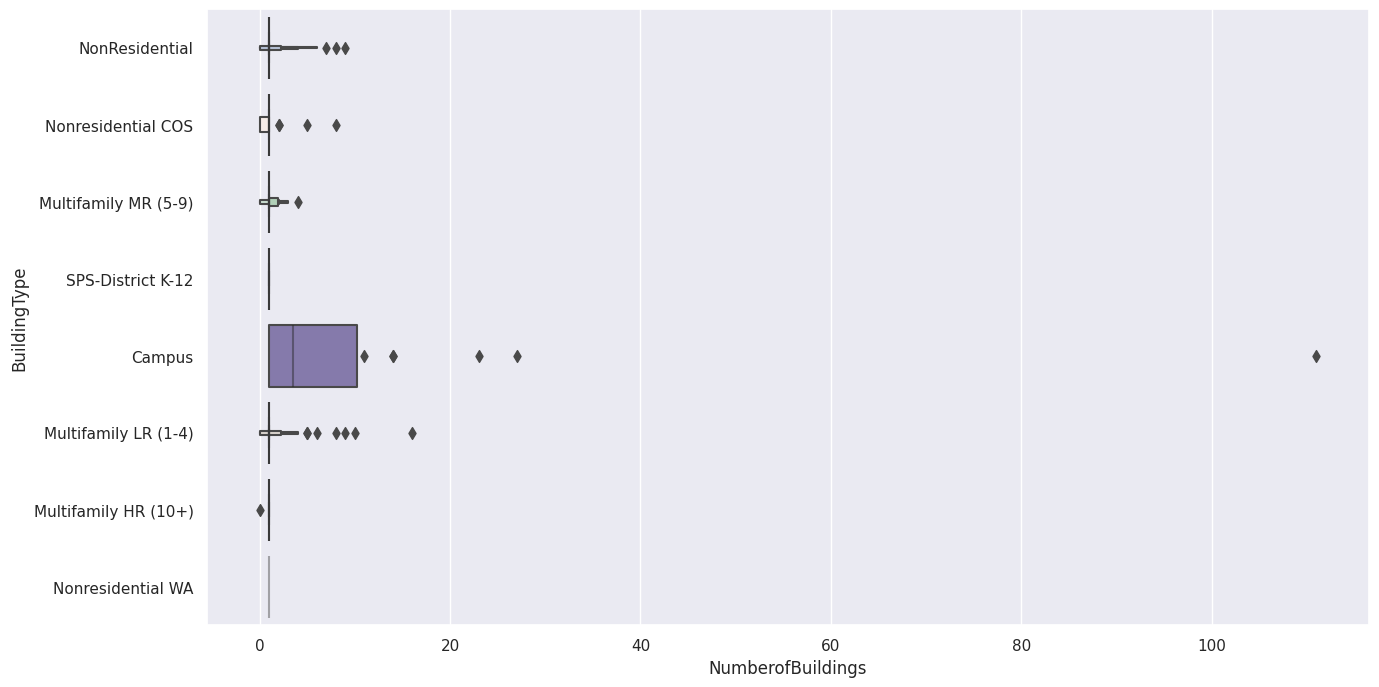

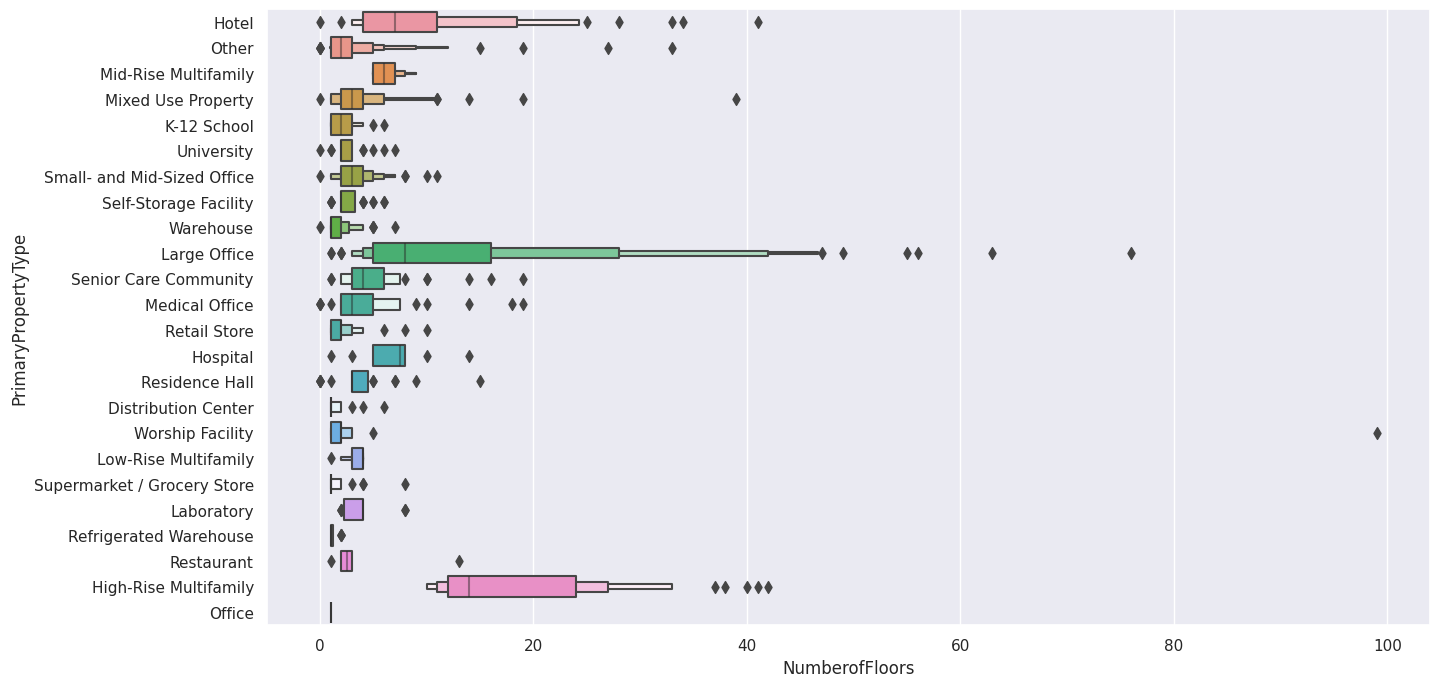

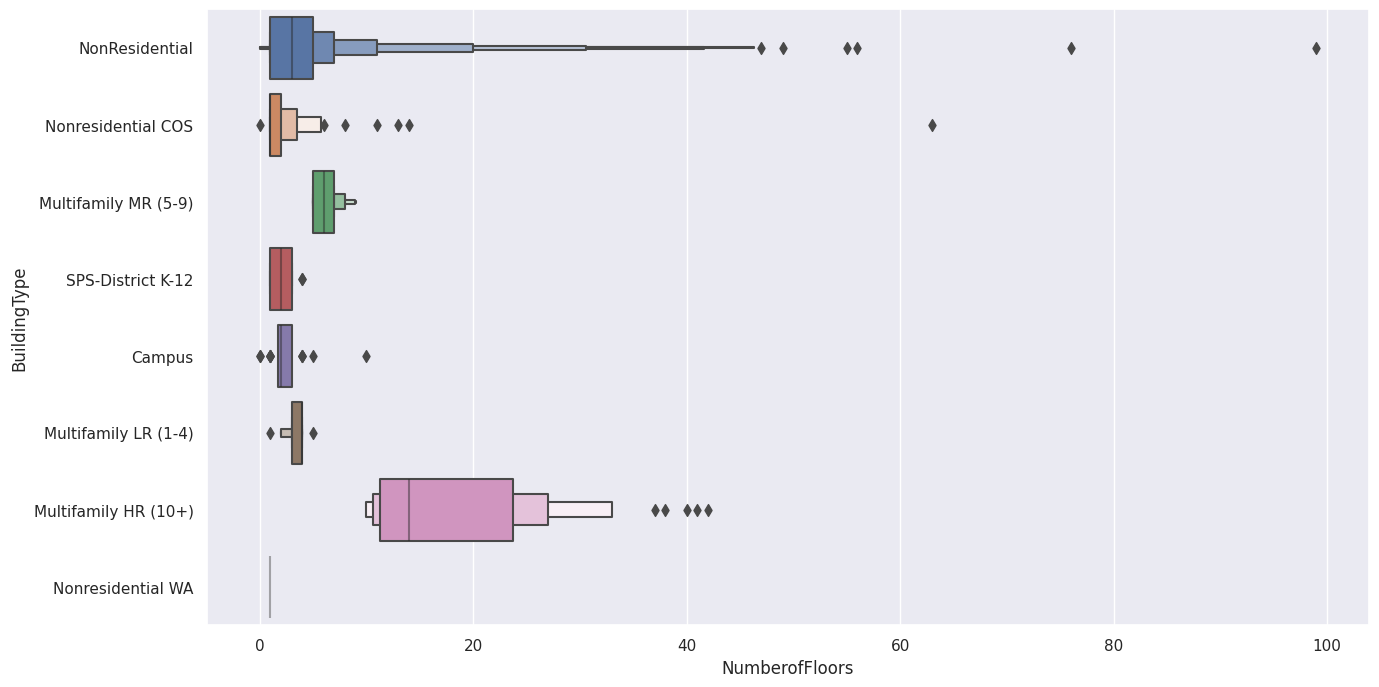

In [43]:
for i in ["NumberofBuildings", "NumberofFloors"]:
    for j in ["PrimaryPropertyType", "BuildingType"]:
        sns.boxenplot(
            y=build_ener_df[j],
            x=build_ener_df[i],
        )
        sns.set(rc={"figure.figsize": (15, 8)})
        plt.show()


* Numeric encoding on all categorical

* LargestPropertyUseType
    * SiteEUI [high is bad](0 to highest -> 0 to 100)
    * GHGEmissionsIntensity [high is bad](0 to highest -> 0 to 100)
    * ENERGYSTARScore [high is good](reversed -> 0 to 100)

    * PropertyGFATotal
        * SiteEnergyUse
        * TotalGHGEmissions

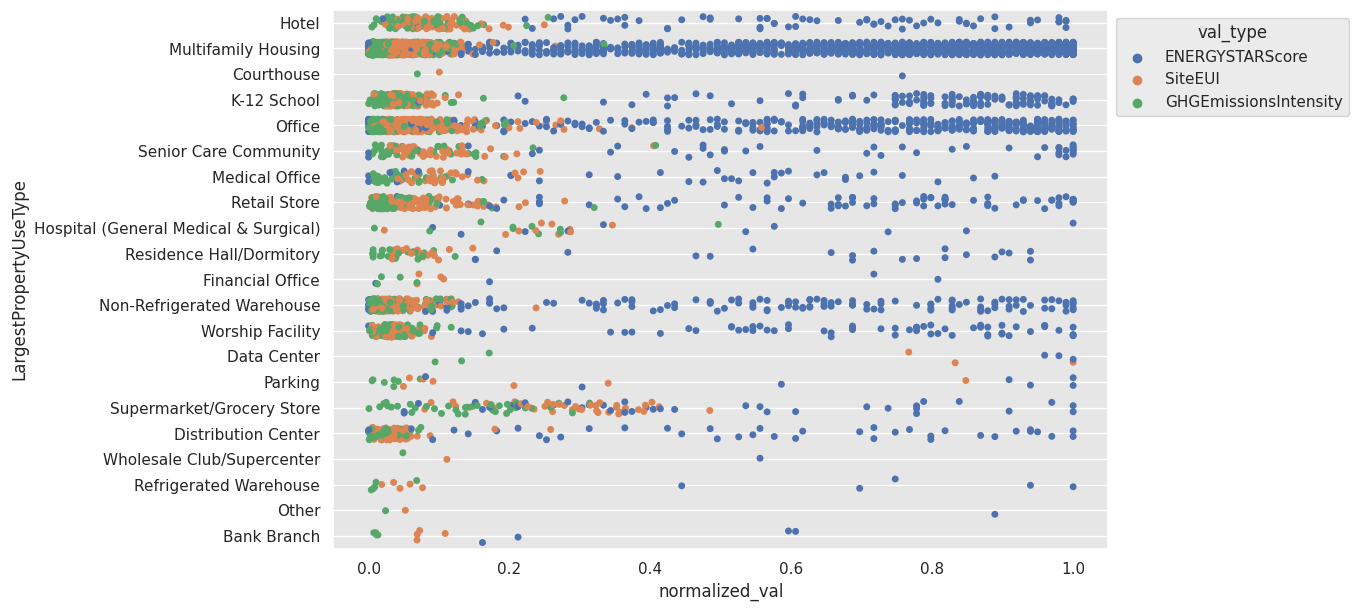

In [42]:
# print(
#     '"LargestPropertyUseType" unique entries:\n\t'
#     + "\n\t".join(sorted([f"{i}" for i in set(build_ener_df["LargestPropertyUseType"].to_numpy())]))
# )

prop_use_df = build_ener_df[
    [
        "LargestPropertyUseType",
        "ENERGYSTARScore",
        "SiteEUI(kBtu/sf)",
        "GHGEmissionsIntensity",
    ]
]
prop_use_df = prop_use_df.rename(columns={"SiteEUI(kBtu/sf)": "SiteEUI"})
prop_use_df = prop_use_df.dropna()

prop_use_df.reset_index(drop=True, inplace=True)

min_max_scaler = lambda x: (x - x.min()) / (x.max() - x.min())

for col in ["ENERGYSTARScore", "SiteEUI", "GHGEmissionsIntensity"]:
    prop_use_df[col] = min_max_scaler(prop_use_df[col])


def to_normal_vals(row):
    new_rows = {"LargestPropertyUseType": [], "normalized_val": [], "val_type": []}

    for col in ["ENERGYSTARScore", "SiteEUI", "GHGEmissionsIntensity"]:
        new_rows["LargestPropertyUseType"] += [row["LargestPropertyUseType"]]
        new_rows["normalized_val"] += [row[col]]
        new_rows["val_type"] += [col]

    return pd.DataFrame(new_rows)


prop_use_df = pd.concat(
    prop_use_df.apply(to_normal_vals, axis=1).to_list(), ignore_index=True
)

fig, ax = plt.subplots(figsize=(10, 7))
sns.stripplot(
    data=prop_use_df,
    x="normalized_val",
    y="LargestPropertyUseType",
    # kind="scatter",
    hue="val_type",
    jitter=0.25,
    ax=ax,
)
# sns.set(rc={"figure.figsize": (15, 8)})
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.grid()
plt.show()

# siteeui_max = prop_use_df["SiteEUI"].max()
# enerstar_at_siteeui_max = prop_use_df.loc[prop_use_df["SiteEUI"] == siteeui_max]
# enerstar_at_siteeui_max
# ghgei_max = prop_use_df["GHGEmissionsIntensity"].max()
# with pd.option_context("mode.chained_assignment", None):
#     prop_use_df["ENERGYSTARScore"] = prop_use_df["ENERGYSTARScore"].apply(lambda x: 100 - x)
#     prop_use_df["SiteEUI"] = prop_use_df["SiteEUI"].apply(lambda x:  x * 100 / siteeui_max)
#     prop_use_df["GHGEmissionsIntensity"] = prop_use_df["GHGEmissionsIntensity"].apply(lambda x:  x * 100 / ghgei_max)
# prop_use_df
